# Williams et al. (2025) ApJ XX, YY
Tutorial notebook on using the data from this living dataset. At the time of publication there are 144 regions.
65 of these have X-ray flare class exceeding C1.0 and are deemed to be flaring active regions. The other 79 
regions are subsequently classed as non-flaring. 


Full details can be found here: INSERT LINK


Author of this Notebook: Dr T. Williams PhD, MPhys, PGCTHE, FHEA

contact: tomwilliamsphd(at)gmail.com

# import all modules

In [57]:
import pickle, os, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from multiprocessing import Pool

# load the database

In [58]:
file = open('ARTop_Processed_Regions.pkl','rb')
db = pickle.load(file)
file.close()
del file

# list all the active regions by SHARP number contained within the database

In [59]:
sharps = []
for sharp in db.keys(): sharps.append(sharp)

print(sharps)

['8', '14', '14_David', '17', '17_David', '26', '43', '45', '49', '51', '54', '83', '86', '116', '131', '156', '219', '221', '274', '285', '316', '318', '325', '335', '347', '354', '366', '367', '377', '384', '394', '401_David', '421', '421_David', '429', '436', '437', '438', '527', '540', '572', '589', '589_David', '595', '602', '619', '622', '625', '686', '700', '705', '713', '799', '824', '833', '851', '875', '877', '892', '926', '940', '956', '982', '990', '1028', '1041', '1080', '1170', '1209', '1232', '1303', '1312', '1399', '1449', '1449_David', '1464', '1528', '1558', '1594', '1611', '1644', '1688', '1877', '1886', '1942', '1990', '1997', '2007', '2036', '2121', '2158', '2191', '2262', '2348', '2436', '2501', '2560', '2635', '2711', '2754', '2832', '2922', '2976', '3028', '3097', '3122', '3309', '3353', '3420', '3448', '3515', '3560', '3686', '3741', '3813', '3853', '3907', '3999', '4075', '4131', '4231', '4328', '4698', '5107', '5298', '7115', '590', '590_David', '245', '1389'

In [60]:
# Some regions are assigned the name _David after their number. These regions have been processed with a velocity smoothing
# VS = 20. The other regions are processed with VS = 12.

# These can be removed by:
sharps = []
for sharp in db.keys(): 
    if sharp[-1] != 'd':
        sharps.append(sharp)
print(sharps)

['8', '14', '17', '26', '43', '45', '49', '51', '54', '83', '86', '116', '131', '156', '219', '221', '274', '285', '316', '318', '325', '335', '347', '354', '366', '367', '377', '384', '394', '421', '429', '436', '437', '438', '527', '540', '572', '589', '595', '602', '619', '622', '625', '686', '700', '705', '713', '799', '824', '833', '851', '875', '877', '892', '926', '940', '956', '982', '990', '1028', '1041', '1080', '1170', '1209', '1232', '1303', '1312', '1399', '1449', '1464', '1528', '1558', '1594', '1611', '1644', '1688', '1877', '1886', '1942', '1990', '1997', '2007', '2036', '2121', '2158', '2191', '2262', '2348', '2436', '2501', '2560', '2635', '2711', '2754', '2832', '2922', '2976', '3028', '3097', '3122', '3309', '3353', '3420', '3448', '3515', '3560', '3686', '3741', '3813', '3853', '3907', '3999', '4075', '4131', '4231', '4328', '4698', '5107', '5298', '7115', '590', '245', '1389', '1480', '1497', '1564', '1578', '1863', '1943', '1948', '1638', '3079', '2748', '2337', 

# query how many regions in db

In [61]:
print(f'\nThere are {len(sharps)} active regions in this dataset.')


There are 144 active regions in this dataset.


# define the flare score
currently the one in db uses log which makes classification harder

In [62]:
# we can use this with the next function to replace the flare score in the db variable.
def flare_score(mag):
    """
    input:
            mag: list or array containing all the GOES magnitudes
                 as strings
    return:
            floating-point value indicating total flare energy from
            list in non-dimensional units
    """
    score = 0
    for m in mag:
        try:
            if m[0] == 'C':
                base = 1e1
            if m[0] == 'M':
                base = 1e2
            if m[0] == 'X':
                base = 1e3
            fact = m[1:]
            score += float(fact)*base
        except:
            score += 0
    #if score > 0:
    #    score /= 1e4
    if score > 1e4: 
        score = 1e4
    return score

# create a dataframe for a given sharp region using the db (database) from the imported pickle file.

In [63]:
# NB: the database is a dictionary of pd.DataFrames but some features are missing, like the current-carrying
# component of the magnetic helicity and winding.
def makeData(sharp):
    from __main__ import db
    dl = np.asarray(db[sharp]['series']['dL'])
    dh = np.asarray(db[sharp]['series']['dH'])

    # compute dLc
    indl = np.where(dl < 0)
    dLpos = dl
    dLpos[indl] = 0

    # compute dHc
    indh = np.where(dh < 0)
    dHpos = dh
    dHpos[indh] = 0

    # compute dLc integrated
    dLc_int = dLpos*0.
    dLc_int[0] = dLpos[0]
    for it in range(1,len(dLpos)):
        dLc_int[it] = dLc_int[it-1] + dLpos[it]
    
    # compute dHc integrated
    dHc_int = dHpos*0.
    dHc_int[0] = dHpos[0]
    for it in range(1,len(dHpos)):
        dHc_int[it] = dHc_int[it-1] + dHpos[it]
    
    db[sharp]['series']['dLpos'] = dLpos
    db[sharp]['series']['dHpos'] = dHpos
    db[sharp]['integrated']['dLc_int'] = dLc_int
    db[sharp]['integrated']['dHc_int'] = dHc_int
    
    
    # scalar correction for the  int_ quantities
    ################################################
    #db[key]['integrated']['dL_int'] *= 720
    #db[key]['integrated']['dH_int'] *= 720


    # implement the kurtoses into the series data
    ################################################
    kindex = 0     #   (0): 3 hour;  (1): 6 hour;   (2): 12 hour.
    ser = db[sharp]['series']
    old = db[sharp]['kurtosis'][kindex]
    
    kur = pd.DataFrame()
    kur['times(seconds)'] = np.asarray(old['Time'])

    dl = np.asarray(ser['dLpos'])
    dh = np.asarray(ser['dHpos'])
    nt = len(dl)

    # averagimg windows of the last 3, 6, 12 hours for kurtosis distribution calculations
    windows = [3,6,12]
    window = windows[kindex]/0.2
    t0,tf = 0, int(window)
    tmp1,tmp2 = [],[]
 
    while tf < nt:
        tmp1.append(kurtosis(dl[t0:tf]))
        tmp2.append(kurtosis(dh[t0:tf]))
        t0 += 1
        tf += 1

    # replace kurtoses of dL and dH with kurtoses of dLc and dHc
    old['dL'] = tmp1
    old['dH'] = tmp2

    for k,kkey in enumerate(old.keys()):
        if k != 0:
            kur['kurt_'+kkey] = np.asarray(old[kkey])
    
    res = pd.merge(ser,kur, how='left', on='times(seconds)')
    res['limb'] = db[sharp]['limb']      


    
    
    # Create flare score arrays for up to 3, 6, 12, 24, and 48 hr ahead.
    flares = db[sharp]['flares']
    flare_start = np.asarray(flares['flare_start'])
    flare_end = np.asarray(flares['flare_end'])
    flare_mag = np.asarray(flares['flare_mag'])
    
    t = np.asarray(db[sharp]['series']['times(seconds)'])
    nt = len(t)
    
    plus_time = [3,6,12,24,48]
    flare_scores = []
    tnew = []
    
    for plus in plus_time:
        count = plus
        fscores = []
        if len(flares) > 0:
            for it in range(int(plus/0.2),nt):
                tfin = t[it]
                tnow = tfin - plus
                fmag = []
                for ij in range(len(flare_start)):
                    fs = float(flare_start[ij])
                    fe = float(flare_end[ij])
                    f = flare_mag[ij]
                    if (fs >= tnow and fs <= tfin) \
                    or (fe >= tnow and fe <= tfin):
                        fmag.append(f)
                fscores.append(flare_score(fmag))
        else:
            fscores = list(np.zeros(nt))
        flare_scores.append(fscores)
    

    for it in range(len(plus_time)):
        tmp = np.asarray(flare_scores[it])
        lnth = len(tmp)
        ln = nt-lnth
        tmp2 = np.zeros(nt)
        tmp2[ln:] = tmp
        res['flare'+str(plus_time[it])+'hr'] = tmp2

    del plus_time, plus, tmp, tmp2, ln, lnth, it, flare_scores
    
    return res

# utilise multi-processing to speed-up the creation of the new database with our updated stats

In [64]:
if __name__ == '__main__':
    with Pool(int(os.cpu_count())) as pool:
        dfList = list(tqdm.tqdm(pool.imap(makeData,sharps),
                              total = len(sharps))
                     )
data = {}
for i,sharp in enumerate(sharps):
    data[sharp] = dfList[i]

100%|█████████████████████████████████████████| 144/144 [00:08<00:00, 16.78it/s]


In [65]:
# Let's look at what has been created
display(data[sharps[0]].head())

print(data[sharps[0]].keys())

,times(seconds),bz,vz,sz,dL,dH,vz_dL_pos,vz_dH_pos,vzbz,flare6hr,...,kurt_bz,kurt_vz,kurt_sz,kurt_dL,kurt_dH,kurt_vz_dL_pos,kurt_vz_dH_pos,kurt_vzbz,limb,flare3hr
0,0.0,-7.261643e+10,-2.538568e+07,1.818693e+11,2.526069e+12,2.608061e+15,-6.692624e+09,-4.094099e+13,-1.675118e+09,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,0.2,-7.502907e+10,-5.500223e+07,1.154204e+11,5.581750e+12,2.158485e+15,-1.064073e+10,-8.097001e+12,-2.587148e+09,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,0.4,-8.852978e+10,-2.877874e+07,3.328066e+11,1.444057e+12,3.466406e+15,6.462528e+09,-4.868059e+13,-1.047355e+09,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,0.6,-9.159094e+10,-3.965101e+07,-9.764858e+10,3.706723e+12,7.004260e+15,7.050973e+09,-7.940836e+13,-2.718113e+09,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,0.8,-8.323025e+10,-7.355947e+07,-7.661304e+10,1.598462e+12,5.223380e+14,-9.579989e+09,3.952987e+12,-3.452363e+09,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


Index(['times(seconds)', 'bz', 'vz', 'sz', 'dL', 'dH', 'vz_dL_pos',
       'vz_dH_pos', 'vzbz', 'flare6hr', 'flare12hr', 'flare24hr', 'flare48hr',
       'dLpos', 'dHpos', 'kurt_bz', 'kurt_vz', 'kurt_sz', 'kurt_dL', 'kurt_dH',
       'kurt_vz_dL_pos', 'kurt_vz_dH_pos', 'kurt_vzbz', 'limb', 'flare3hr'],
      dtype='object')


here, dL, dH, dLpos, dHpos, vz_dL_pos, vz_dH_pos are the rates of the winding and helicity quantities.
suffix pos denotes current-carrying component only.

kurt_ are the running excess kurtosis time-series for the quantities that follow in the suffix
using a 3-hour period. This can be changed in the makeData function by changing kindex.

flare6hr, flare12hr, flare24hr, flare48hr are series data that aim to quantify the total flare power 
over the next 6, 12, 24, and 48 hours, respectively. In a machine learning model, these would be the y
variables.

The quantity limb provides the percentage of pixels within the SHARP that >= +-60 deg longitude i.e. 
how reliable is the data at any given time?

# Let's look at a time-series plot

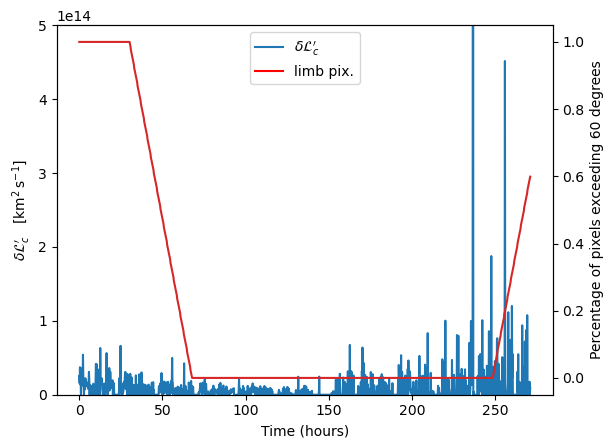

In [73]:
sharp = '7115' # This is NOAA AR 12673; a well documented region.

region = data[sharp] # isolate the series data
flares = db[sharp]['flares'] # this contains the individual flare information for AR 12673 (SHARP 7115)

t = np.asarray(region['times(seconds)'])
dLc = np.asarray(region['dLpos'])
limb = np.asarray(region['limb'])

fig, ax1 = plt.subplots()
ax1.plot(t,dLc, label=r'$\delta \mathcal{L}_c^{\prime}$')
ax1.set_ylim(0,5e14) # limit the range due to a massive spike in the winding when region is near +60 deg longitude
ax1.set_ylabel(r'$\delta \mathcal{L}_c^{\prime}\quad [\mathrm{km}^2\,\mathrm{s}^{-1}]$')
ax1.set_xlabel('Time (hours)')

# plot the limb data
ax2 = ax1.twinx()
ax2.plot(t,limb, color='tab:red')
ax2.set_ylabel('Percentage of pixels exceeding 60 degrees')
ax1.plot([], [], '-r', label = 'limb pix.')

ax1.legend(loc=9)
plt.show()

# create a time-series plot with running mean, 2 sigma envelope, and flare information plotted

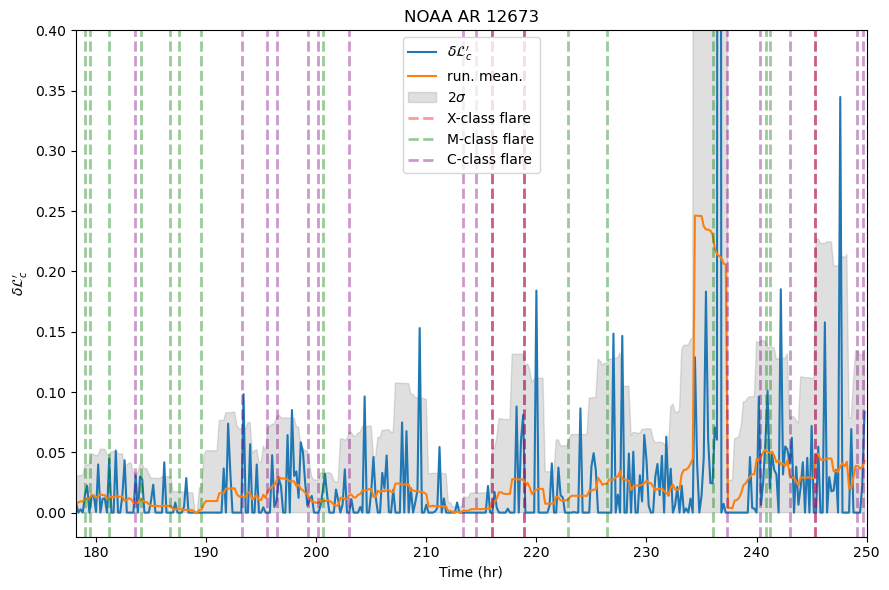

In [67]:
# running mean and std dev function
def running_mean(y, box_pts, std=0):
    #box = np.ones(box_pts)/box_pts
    #y_smooth = np.convolve(y, box, 'valid')
    swv = np.lib.stride_tricks.sliding_window_view
    v = swv(y,box_pts)
    y_smooth = v.mean(axis=-1)
    y_std = v.std(axis=-1)
    if std:
        return y_smooth, std*y_std
    else:
        return y_smooth


# extract individual flare information
flare_start = flares['flare_start']  # these correspond to t=0 in our time series
flare_end   = flares['flare_end']    # these correspond to t=0 in our time series
flare_mag   = flares['flare_mag']    # strings of flare magnitude
flare_long  = flares['flare_x']      # Carrington coordinates of flare origin
flare_lat   = flares['flare_y']      # Carrington coordinates of flare origin


# Determine which magnitude each flare is
xind,mind,cind = [],[],[]
tmp1,tmp2,tmp3 = [],[],[]
for j,f in enumerate(flare_mag):
    if f[0] == 'X':
        tmp1.append(j)
    if f[0] == 'M':
        tmp2.append(j)
    else:
        tmp3.append(j)
xind.append(tmp1)
mind.append(tmp2)
cind.append(tmp3)

x = dLc

f, ax = plt.subplots(1,1,figsize=(9,6))

# make the running mean and 2-sigma envelope for dLc
running = 3 # hours
xbar,xsig = running_mean(x,int(running/0.2),std=2)
# hours to plot between (a-b)
a = 178
b = 250
tmp1 = np.min(np.where(t >= a))
tmp2 = np.max(np.where(t <= b))
a = tmp1
b = tmp2
    
x = x[a:b]
xmax = np.max(x)*0.33  # further trim x because of large spike
xbar = xbar[a-running:b-running]
xsig = xsig[a-running:b-running]

ax.plot(t[a:b], x/xmax, label = r'$\delta \mathcal{L}_{c}^{\prime}$')
ax.plot(t[a:b], xbar/xmax, label = r'run. mean.')
ax.set_xlabel('Time (hr)')
ax.fill_between(t[a:b],xbar/xmax+xsig/xmax,0,
                 color='grey',alpha=0.25, label = r'$2\sigma$')

# plot C, M, and X-class flares in purple, green, red
ft = flare_start
fxt = ft[xind[0]]
fmt = ft[mind[0]]
fct = ft[cind[0]]

count = 0
for ct in fxt:
    if count == 0:
        ax.axvline(x=ct, c='red',ls ="--", lw=2, alpha=0.4, label='X-class flare')
    else:
        ax.axvline(x=ct, c='red',ls ="--", lw=2, alpha=0.4)
    count = 1
    
count = 0
for ct in fmt:
    if count == 0:
        ax.axvline(x=ct, c='green',ls ="--", lw=2, alpha=0.4, label='M-class flare')
    else:
        ax.axvline(x=ct, c='green',ls ="--", lw=2, alpha=0.4)
    count = 1

count = 0
for ct in fct:
    if count == 0:
        ax.axvline(x=ct, c='purple',ls ="--", lw=2, alpha=0.4, label='C-class flare')
    else:
        ax.axvline(x=ct, c='purple',ls ="--", lw=2, alpha=0.4)
    count = 1

ax.set_xlim(t[a],t[b])
ax.set_title('NOAA AR 12673')

ax.set_ylim(-0.02,0.4)

ax.set_ylabel(r'$\delta \mathcal{L}_{c}^{\prime}$')
plt.legend()

plt.tight_layout()

plt.show()


# example plot for the accumulated quantities

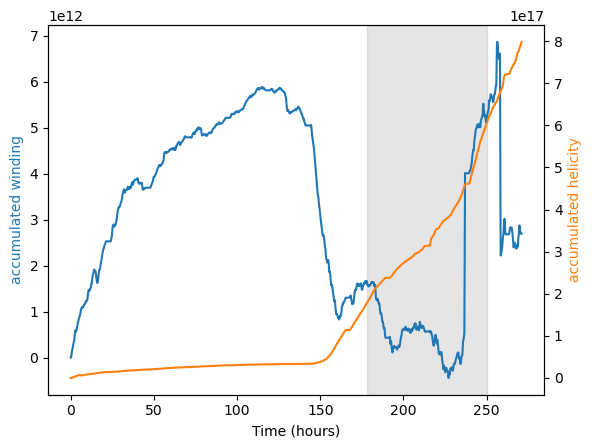

In [68]:
integrals = db[sharp]['integrated'] # this contains the accumulated winding and helicity time-series

accum_dL = integrals['dL_int']
accum_dH = integrals['dH_int']

fig, ax1 = plt.subplots()
ax1.plot(t,accum_dL)
ax1.set_ylabel(r'accumulated winding')
ax1.set_xlabel('Time (hours)')

# plot the limb data
ax2 = ax1.twinx()
ax2.plot(t,accum_dH, color='tab:orange')
ax2.set_ylabel('accumulated helicity')

# shade region corresponding to the plot above
ax1.axvspan(t[a],t[b],alpha=0.2, color='gray')

# colour-coordinate y axes and plots
ax1.yaxis.label.set_color('tab:blue')
ax2.yaxis.label.set_color('tab:orange')

plt.show()